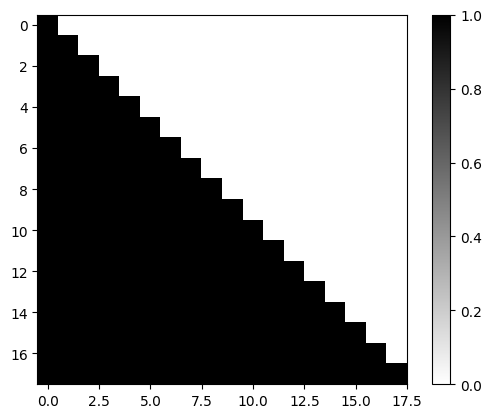

In [1]:
import numpy as np
import matplotlib.pyplot as plt

matrix = np.zeros((18, 18))


np.fill_diagonal(matrix, 1)
for i in range(18):
  matrix[i, :i] = 1

# Display the matrix
plt.imshow(matrix, cmap='binary', interpolation='nearest')
plt.colorbar()
plt.show()

In [7]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-german-cased")

ls = [102, 12402, 2856, 212, 2708, 3585, 106, 19247, 143, 12384, 10450, 5127, 932, 566, 103, 0]
for ele in ls:
    print(ele, tokenizer.convert_ids_to_tokens(ele))

102 [CLS]
12402 Mehrere
2856 Männer
212 mit
2708 Schutz
3585 ##helm
106 ##en
19247 bedienen
143 ein
12384 Antrieb
10450 ##sr
5127 ##ads
932 ##ystem
566 .
103 [SEP]
0 [PAD]


In [8]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

ls = [101, 2195, 2273, 1999, 2524, 16717, 2024, 4082, 1037, 5016, 4139, 3240, 2291, 1012]
for ele in ls:
    print(ele, tokenizer.convert_ids_to_tokens(ele))

101 [CLS]
2195 several
2273 men
1999 in
2524 hard
16717 hats
2024 are
4082 operating
1037 a
5016 giant
4139 pull
3240 ##ey
2291 system
1012 .


In [1]:
import cv2
import numpy as np
import torch

class TSPImageDataset(torch.utils.data.Dataset):
  def __init__(self, data_file, img_size, point_radius=2, point_color=1, line_thickness=2, line_color=0.5, max_points=100):
    self.data_file = data_file
    self.img_size = img_size
    self.point_radius = point_radius
    self.point_color = point_color
    self.line_thickness = line_thickness
    self.line_color = line_color
    self.max_points = max_points

    self.file_lines = open(data_file).read().splitlines()
    print(f'Loaded "{data_file}" with {len(self.file_lines)} lines')

  def __len__(self):
    return len(self.file_lines)

  def get_reordered_tsp_instance(self, points, tour):
    point2before_idx = {}
    for idx, point in enumerate(points):
        point2before_idx[tuple(point)] = idx + 1

    center_of_mass = np.mean(points, axis=0)
    coordinates = np.array(points)
    centered_coordinates = coordinates - center_of_mass
    angles = np.arctan2(centered_coordinates[:, 1], centered_coordinates[:, 0])
    scaled_angles = (angles + 2 * np.pi) % (2 * np.pi)
    # print(scaled_angles)
    distances = np.sqrt(centered_coordinates[:, 0] ** 2 + centered_coordinates[:, 1] ** 2)
    reordered_points = coordinates[np.lexsort((distances, scaled_angles))] # 증가하는 순서대로
    # print(scaled_angles[np.lexsort((distances, scaled_angles))])
    
    before_idx2after_idx = {}
    for idx, point in enumerate(reordered_points):
        before_idx = point2before_idx[tuple(point)]
        before_idx2after_idx[before_idx] = idx + 1
    
    after_tour = []
    for before_idx in tour:
        after_idx = before_idx2after_idx[before_idx]
        after_tour.append(after_idx)
        
    after_tour = np.array(after_tour[:-1])
    one_index = np.where(after_tour == 1)[0][0]
    one_before = after_tour[(one_index - 1 + len(after_tour)) % len(after_tour)]
    one_after = after_tour[(one_index + 1 + len(after_tour)) % len(after_tour)]

    if one_after < one_before:
        reordered_tour = np.roll(after_tour, -one_index)
    else:
        reordered_tour = np.roll(after_tour, len(after_tour) - one_index - 1)[::-1]
    
    reordered_tour = np.append(reordered_tour, 1)
        
    return reordered_points, reordered_tour, center_of_mass

  def rasterize(self, idx):
    # Select sample
    line = self.file_lines[idx]
    # Clear leading/trailing characters
    line = line.strip()

    # Extract points
    points = line.split(' output ')[0]
    points = points.split(' ')
    points = np.array([[float(points[i]), float(points[i + 1])] for i in range(0, len(points), 2)])
    # Extract tour
    tour = line.split(' output ')[1]
    tour = tour.split(' ')
    tour = np.array([int(t) for t in tour])
    
    # Rasterize lines
    img = np.zeros((self.img_size, self.img_size))
    
    # points, tour, center_of_mass = self.get_reordered_tsp_instance(points, tour) # reorder points, tour
    # cv2.circle(img, ((self.img_size - 1) * center_of_mass).astype(int), radius=self.point_radius, color=self.point_color, thickness=-1)
    
    for i in range(tour.shape[0] - 1):
      from_idx = tour[i] - 1
      to_idx = tour[i + 1] - 1

      cv2.line(img,
               ((self.img_size - 1) * points[from_idx, ::-1]).astype(int),
               ((self.img_size - 1) * points[to_idx, ::-1]).astype(int),
               color=self.line_color, thickness=self.line_thickness)

    for i in range(len(tour)):
      point = ((self.img_size - 1) * points[tour[i] - 1, ::-1]).astype(int)
      cv2.circle(img, point, radius=self.point_radius, color=self.point_color, thickness=-1)
      text_position = (point[0] - 10, point[1] - 10)
      cv2.putText(img, str(tour[i]), text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 1, cv2.LINE_AA)  

    # Rescale image to [-1,1]
    img = 2 * (img - 0.5)

    return img, points, tour

  def __getitem__(self, idx):
    img, points, tour = self.rasterize(idx)
    return img, points, tour

In [2]:
images = TSPImageDataset(
    data_file = "./reordered_tsp20_train_concorde.txt", 
    img_size = 640, 
    point_radius = 5, 
    point_color = 250, 
    line_thickness = 2,
    line_color = 200,
    max_points = 100
)

Loaded "./reordered_tsp20_train_concorde.txt" with 10000 lines


tour: [ 1  3  5  2  4  7  8  6  9 10 11 14 16 13 12 15 17 18 19 20  1]


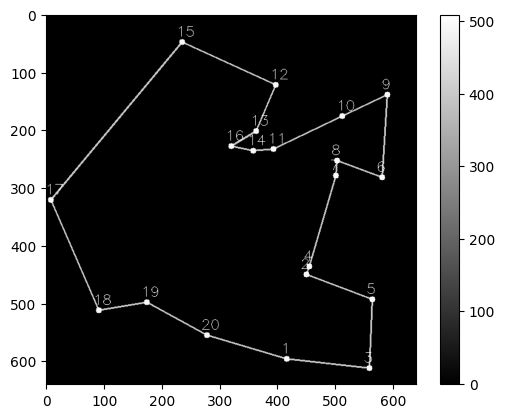

In [3]:
import matplotlib.pyplot as plt

img, points, tour = images[0]

print("tour:", tour)
plt.imshow(img, cmap='gray')
plt.colorbar()
plt.show()    

100 100
[1278 6703 8961 9207  537 2668 9377 4334 5235 2739 2111 5196 3189 4867
 4161 2537 8921 3165  333 5710 2490 3351 3806 6384 8298  132 4885 5508
 9160 5502 9419 5861 5896 4826 1147 4102 6511 2534 5811 5062 6407 4607
 1680 5598 7346 1154 8077 6052 2785 6690 2247  167 9236 4195 6668   19
 6083 5628 6707 9231 3348 7374 1911 2594 7387 4654 5763 1237 2838 5144
 2874 7483  540 7198  663  978 1959 8407   68 1937 7171 8218 2664 2389
 7744 2008 6599 8602 6894 5586 3731 2772 4369 3833 4210 7946 3693 6087
 9686  408]
[7171, 4102, 6668, 9231, 19, 9236, 5144, 537, 8218, 540, 7198, 6690, 2594, 4654, 6703, 6707, 2111, 7744, 4161, 68, 5196, 5710, 3165, 4195, 2664, 8298, 2668, 3693, 4210, 5235, 3189, 1147, 1154, 5763, 132, 1680, 3731, 663, 9377, 167, 7346, 2739, 5811, 2247, 9419, 7374, 2772, 1237, 8407, 8921, 4826, 7387, 3806, 2785, 5861, 4334, 6894, 6384, 3833, 1278, 8961, 4867, 6407, 5896, 7946, 4369, 3348, 4885, 2838, 3351, 2874, 7483, 333, 2389, 6511, 1911, 5502, 5508, 8077, 1937, 408, 8602, 6

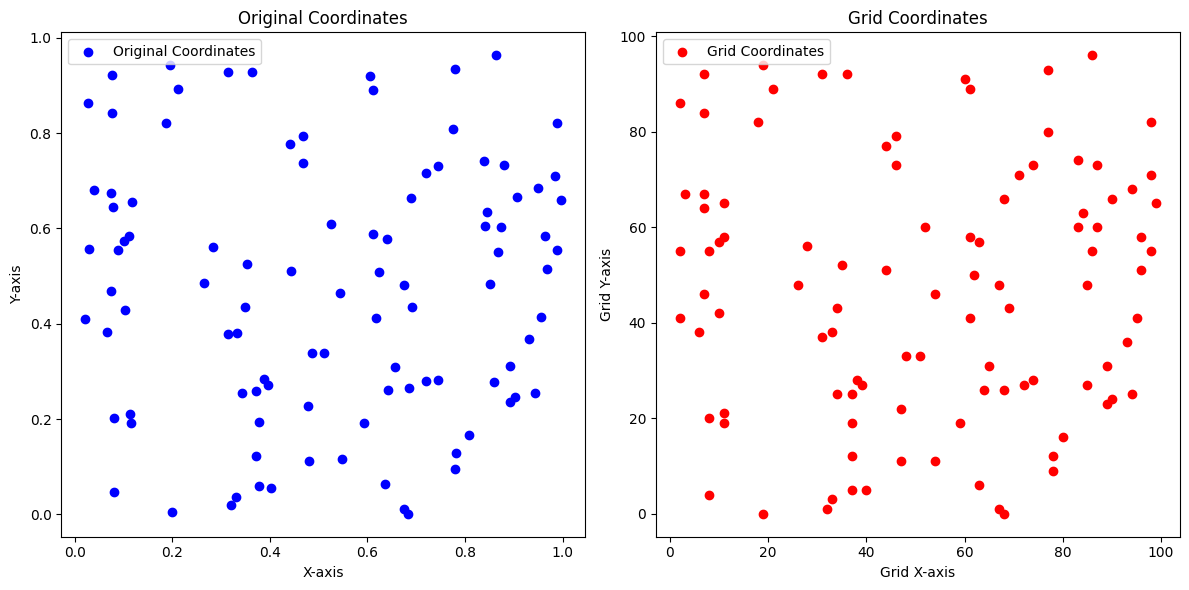

In [3]:
import numpy as np
import matplotlib.pyplot as plt

num_nodes = 100  # 예시로 사용된 노드의 수
grid_size = 100  # 예시로 사용된 그리드의 크기

# 무작위로 좌표 생성
nodes_coord = np.random.random([num_nodes, 2])

# 그리드 크기로 스케일링 및 정수화
nodes_coord_scaled = (nodes_coord * grid_size).astype(int)

# 2D 좌표를 1D 인덱스로 변환
grid_indices = nodes_coord_scaled[:, 0] + nodes_coord_scaled[:, 1] * grid_size
unique_grid_indices = list(set(grid_indices))

print(len(grid_indices), len(unique_grid_indices))
print(grid_indices)
print(unique_grid_indices)

# 그림 그리기
plt.figure(figsize=(12, 6))

# 그리드로 바꾸기 전의 좌표
plt.subplot(1, 2, 1)
plt.scatter(nodes_coord[:, 0], nodes_coord[:, 1], c='b', label='Original Coordinates')
plt.title('Original Coordinates')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# 그리드로 바꾼 후의 좌표
plt.subplot(1, 2, 2)
plt.scatter(nodes_coord_scaled[:, 0], nodes_coord_scaled[:, 1], c='r', label='Grid Coordinates')
plt.title('Grid Coordinates')
plt.xlabel('Grid X-axis')
plt.ylabel('Grid Y-axis')
plt.legend()

plt.tight_layout()
plt.show()


In [3]:
import cv2
import numpy as np
import torch

class TSPImageDataset(torch.utils.data.Dataset):
  def __init__(self, data_file):
    self.data_file = data_file
    
    self.file_lines = open(data_file).read().splitlines()
    print(f'Loaded "{data_file}" with {len(self.file_lines)} lines')

  def __len__(self):
    return len(self.file_lines)

  def rasterize(self, idx):
    # Select sample
    line = self.file_lines[idx]
    # Clear leading/trailing characters
    line = line.strip()

    # Extract points
    points = line.split(' output ')[0]
    points = points.split(' ')
    points = np.array([[float(points[i]), float(points[i + 1])] for i in range(0, len(points), 2)])
    # Extract tour
    tour = line.split(' output ')[1]
    tour = tour.split(' ')
    tour = np.array([int(t) for t in tour])
    
    return points, tour

  def __getitem__(self, idx):
    points, tour = self.rasterize(idx)
    return points, tour

In [5]:
images = TSPImageDataset(
    data_file = "./tsp20_grid_test.txt", 
)

Loaded "./tsp20_grid_test.txt" with 10000 lines


In [21]:
import cv2
import numpy as np
import torch

class TSPImageDataset(torch.utils.data.Dataset):
  def __init__(self, data_file):
    self.data_file = data_file
    
    self.file_lines = open(data_file).read().splitlines()
    print(f'Loaded "{data_file}" with {len(self.file_lines)} lines')

  def __len__(self):
    return len(self.file_lines)

  def rasterize(self, idx):
    # Select sample
    line = self.file_lines[idx]
    # Clear leading/trailing characters
    line = line.strip()

    # Extract points
    points = line.split(' output ')[0]
    points = points.split(' ')
    points = np.array([int(points[i]) for i in range(0, len(points))])
    # Extract tour
    tour = line.split(' output ')[1]
    tour = tour.split(' ')
    tour = np.array([int(t) for t in tour])
    
    return points, tour

  def __getitem__(self, idx):
    points, tour = self.rasterize(idx)
    return points, tour

In [51]:
images = TSPImageDataset(
    data_file = "./tsp20_grid_val.txt", 
)

Loaded "./tsp20_grid_val.txt" with 10000 lines


In [52]:
def check_unique_and_return_grid_coord(nodes_coord, grid_size):
    grid_coord = ((nodes_coord * grid_size).astype(int) / grid_size) + 1 / (2 * grid_size)
    grid_indices = grid_coord[:, 0] + grid_coord[:, 1] * grid_size
    unique_grid_indices = list(set(grid_indices))
    
    return len(grid_indices) == len(unique_grid_indices), grid_coord

def graph2grid(nodes_coord, grid_size = 100):
    nodes_coord_scaled = (nodes_coord * grid_size).astype(int)
    grid_indices = nodes_coord_scaled[:, 0] + nodes_coord_scaled[:, 1] * grid_size
    return grid_indices

original_grid_size = 100

count = 0
with open("./tsp20_grid50_val.txt", "w") as file:
    for image in images:
        points, tour = image
        
        point_xs = (points // original_grid_size) / original_grid_size + 1 / (2 * original_grid_size)
        point_ys = (points % original_grid_size) / original_grid_size + 1 / (2 * original_grid_size)
        
        tour_xs = (tour // original_grid_size) / original_grid_size + 1 / (2 * original_grid_size)
        tour_ys = (tour % original_grid_size) / original_grid_size + 1 / (2 * original_grid_size)
        
        point_xy = np.stack([point_xs, point_ys], axis = 1)
        tour_xy = np.stack([tour_xs, tour_ys], axis = 1)
        
        check, _ = check_unique_and_return_grid_coord(point_xy, 50)
        if not check:
            continue
        
        points_indices = graph2grid(point_xy, 50)
        tour_indices = graph2grid(tour_xy, 50)
        
        for idx in points_indices:
            file.write(str(idx))
            file.write(" ")
            
        file.write("output ")
        
        for idx in tour_indices:
            file.write(str(idx))
            file.write(" ")
        file.write("\n")

In [1]:
import time
from functools import reduce

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR

from omegaconf import OmegaConf

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

from torch.utils.data import DataLoader, Dataset

from dataset_inference import TSPDataset, collate_fn, make_tgt_mask
from model import make_model, subsequent_mask
from loss import SimpleLossComputeWithMask, LabelSmoothingWithMask

class TSPModel(pl.LightningModule):
    def __init__(self, cfg):
        super().__init__()
        self.model = make_model(
            grid_size = cfg.grid_size,
            N=cfg.num_layers, 
            d_model=cfg.d_model, 
            d_ff=cfg.d_ff, 
            h=cfg.h, 
            dropout=cfg.dropout,
            encoder_pe_option = cfg.encoder_pe_option,
            decoder_pe_option = cfg.decoder_pe_option,
            use_start_token = cfg.use_start_token,
            share_lut = cfg.share_lut,
            node_size = cfg.node_size
        )
        self.automatic_optimization = False
        
        if cfg.use_start_token:
            criterion = LabelSmoothingWithMask(size = cfg.grid_size * cfg.grid_size + 1 , smoothing=cfg.smoothing)
        else:
            criterion = LabelSmoothingWithMask(size = cfg.grid_size * cfg.grid_size , smoothing=cfg.smoothing)
        self.loss_compute = SimpleLossComputeWithMask(self.model.generator, criterion)
    
        self.set_cfg(cfg)
        self.test_corrects = []
        self.test_optimal_tour_distances = []
        self.test_predicted_tour_distances = []
        
    def set_cfg(self, cfg):
        self.cfg = cfg
        self.save_hyperparameters(cfg)  # save config file with pytorch lightening

    def test_dataloader(self):
        self.test_dataset = TSPDataset(self.cfg.test_data_path, self.cfg.grid_size, cfg.use_start_token)
        test_dataloader = DataLoader(
            self.test_dataset, 
            batch_size = self.cfg.test_batch_size, 
            shuffle = False, 
            collate_fn = collate_fn,
            pin_memory=True
        )
        return test_dataloader

    def test_step(self, batch, batch_idx):
        src = batch["src"]
        tgt = batch["tgt"]
        visited_mask = batch["visited_mask"]
        ntokens = batch["ntokens"]
        tgt_mask = batch["tgt_mask"]
        tsp_tours = batch["tsp_tours"]
        reversed_tsp_tours = batch["reversed_tsp_tours"]
        
        batch_size = tsp_tours.shape[0]
        
        self.model.eval()
        with torch.no_grad():
            memory = self.model.encode(src)
            ys = tgt.clone()
            visited_mask = visited_mask.clone()
            for i in range(self.cfg.node_size - 1):
                # memory, tgt, tgt_mask
                tgt_mask = subsequent_mask(ys.size(1)).type(torch.bool).to(src.device)
                out = self.model.decode(memory, ys, tgt_mask)
                prob = self.model.generator(out[:, -1], visited_mask)
                _, next_word = torch.max(prob, dim=1)
                
                visited_mask[torch.arange(batch_size), next_word] = True
                ys = torch.cat([ys, next_word.unsqueeze(-1)], dim=1)

            if cfg.use_start_token:
                ys = ys[:, 1:]
        
        correct = []
        for idx in range(batch_size):
            straight_correct = (ys[idx] == tsp_tours[idx]).sum(-1)
            reversed_correct = (ys[idx] == reversed_tsp_tours[idx]).sum(-1)
            if straight_correct < reversed_correct:
                correct.append(reversed_correct)
            else:
                correct.append(straight_correct)
        
        correct = torch.tensor(correct)
        optimal_tour_distance = self.get_tour_distance(tsp_tours)
        predicted_tour_distance = self.get_tour_distance(ys)
        
        result = {
            "correct": correct.tolist(),
            "optimal_tour_distance": optimal_tour_distance.tolist(),
            "predicted_tour_distance": predicted_tour_distance.tolist(),
            }    
        
        self.test_corrects.extend(result["correct"])
        self.test_optimal_tour_distances.extend(result["optimal_tour_distance"])
        self.test_predicted_tour_distances.extend(result["predicted_tour_distance"])

        """
        if self.trainer.is_global_zero:
            for idx in range(batch_size):
                print()
                print("predicted tour: ", ys[idx].tolist())
                print("optimal tour: ", tsp_tours[idx].tolist())
                print("opt, pred tour distance: ", optimal_tour_distance[idx].item(), predicted_tour_distance[idx].item())
                print("optimality gap: ", ((predicted_tour_distance[idx].item() - optimal_tour_distance[idx].item()) / optimal_tour_distance[idx].item()) * 100, "%")
                print("node prediction [hit ratio]: ", (correct[idx].item() / self.cfg.node_size) * 100 , "%")
                print()
        """

        return result
    
    def get_tour_distance(self, ordered_seq):
        x_coordinates = (ordered_seq % self.cfg.grid_size) / self.cfg.grid_size  + 1 / (2 * self.cfg.grid_size)
        y_coordinates = (ordered_seq // self.cfg.grid_size) / self.cfg.grid_size  + 1 / (2 * self.cfg.grid_size)
        coordinates = torch.stack([x_coordinates, y_coordinates], dim=-1)
        rolled_coordinates = coordinates.roll(dims = 1, shifts = -1)
        segment_lengths = ((coordinates - rolled_coordinates) ** 2).sum(-1).sqrt() # [B, N]
        group_travel_distances = segment_lengths.sum(-1)
        return group_travel_distances
    
    def on_test_epoch_end(self):
        corrects = self.all_gather(self.test_corrects)
        optimal_tour_distances = self.all_gather(self.test_optimal_tour_distances)
        predicted_tour_distances = self.all_gather(self.test_predicted_tour_distances)
        
        self.test_corrects.clear()
        self.test_optimal_tour_distances.clear()
        self.test_predicted_tour_distances.clear()
        
        if self.trainer.is_global_zero:
            corrects = torch.stack(corrects)
            optimal_tour_distances = torch.stack(optimal_tour_distances)
            predicted_tour_distances = torch.stack(predicted_tour_distances)
            
            correct = corrects.sum().item()
            total = self.cfg.node_size * len(self.test_dataset)
            hit_ratio = (correct / total) * 100
            mean_optimal_tour_distance = optimal_tour_distances.sum().item() / len(self.test_dataset)
            mean_predicted_tour_distance = predicted_tour_distances.sum().item() / len(self.test_dataset)
            mean_opt_gap = (mean_predicted_tour_distance - mean_optimal_tour_distance) / mean_optimal_tour_distance * 100
            self.print(
                f"\ncorrect={correct}",
                f"\ntotal={total}",
                f"\nnode prediction(hit ratio) = {hit_ratio} %",
                f"\nmean_optimal_tour_distance = {mean_optimal_tour_distance}",
                f"\nmean_predicted_tour_distance = {mean_predicted_tour_distance}",
                f"\nmean_opt_gap = {mean_opt_gap}  %",
            )

def check_cfg(cfg):
    if not cfg.encoder_pe_option in ["pe_2d", None]:
        return False
    
    if not cfg.decoder_pe_option in ["pe_2d", "pe_1d_original", "pe_1d_learnable", "pe_1d_circular", None]:
        return False
    
    if cfg.use_start_token:
        if cfg.decoder_pe == "pe_2d":
            return False
        
    return True

if __name__ == "__main__":
    node_size = 20
    cfg = OmegaConf.create({
        "memo": "",
        "train_data_path": f"./tsp{node_size}_grid_train.txt",
        "val_data_path": f"./tsp{node_size}_grid_val.txt",
        "test_data_path": f"./tsp{node_size}_grid_val.txt",
        "node_size": node_size,
        "train_batch_size": 80,
        "val_batch_size": 80,
        "test_batch_size": 80,
        "resume_checkpoint": "./logs/lightning_logs/version_12/checkpoints/TSP20-epoch=645-opt_gap=0.1690.ckpt",
        "gpus": [0, 1, 2, 3],
        "max_epochs": 1000,
        "num_layers": 6,
        "d_model": 128,
        "d_ff": 512,
        "h":8,
        "dropout": 0.1,
        "smoothing": 0.1,
        "seed": 1,
        "lr": 0.5, 
        "betas": (0.9, 0.98),
        "eps": 1e-9,
        "factor": 1.0,
        "warmup": 400,
        "grid_size": 100,
        "encoder_pe_option": "pe_2d", # pe_2d | None
        "decoder_pe_option": "pe_2d", # pe_2d | pe_1d_original | pe_1d_learnable | pe_1d_circular | None
        "use_start_token": False, # Utilize only when [decoder_pe_option] is not using pe_2d.
        "share_lut": False, # encoder, decoder
    })
    
    if not check_cfg(cfg):
        raise ValueError("Check config again!")
    
    pl.seed_everything(cfg.seed)
    
    # tsp_model = TSPModel(cfg)
    
    tsp_model = TSPModel.load_from_checkpoint(cfg.resume_checkpoint)
    
    # build trainer
    trainer = pl.Trainer( 
        default_root_dir="./",
        devices=cfg.gpus,
        accelerator="cuda",
        precision="16-mixed",
        max_epochs=cfg.max_epochs,
        reload_dataloaders_every_n_epochs=0,
        num_sanity_val_steps=0,
    )

Seed set to 1
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


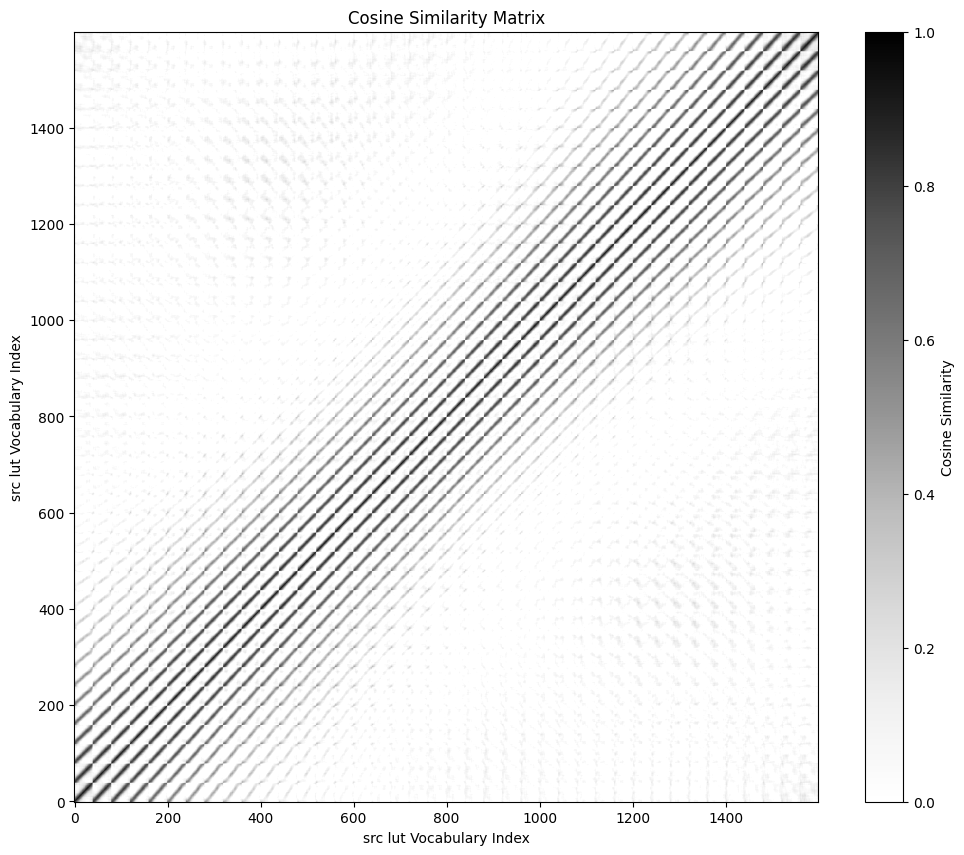

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

tgt_lut_weights = tsp_model.model.tgt_embed.lut.cpu().weight.data
src_lut_weights = tsp_model.model.src_embed.lut.cpu().weight.data

cosine_sim_matrix = cosine_similarity(src_lut_weights, src_lut_weights)

# 시각화
plt.figure(figsize=(12, 10))
plt.imshow(cosine_sim_matrix, cmap='Greys', aspect='auto', vmin=0, vmax=1)
plt.colorbar(label='Cosine Similarity')
plt.title('Cosine Similarity Matrix')
plt.xlabel('src lut Vocabulary Index')
plt.ylabel('src lut Vocabulary Index')
plt.gca().invert_yaxis()
plt.show()

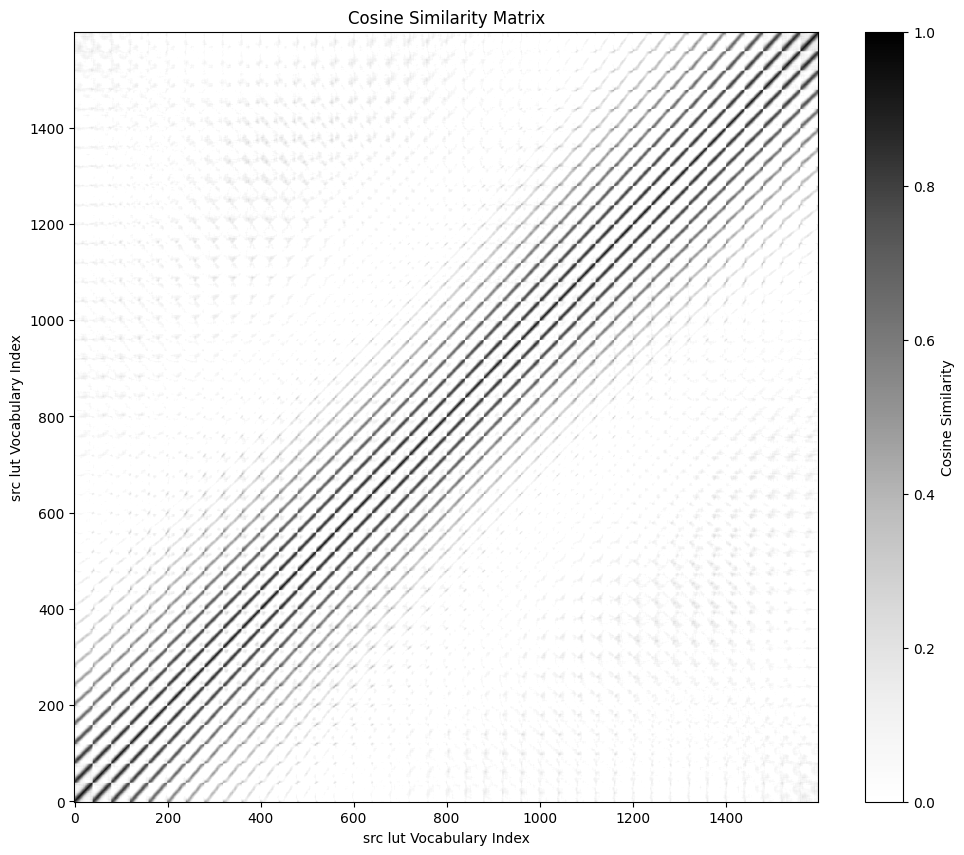

In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

tgt_lut_weights = tsp_model.model.tgt_embed.lut.cpu().weight.data
src_lut_weights = tsp_model.model.src_embed.lut.cpu().weight.data

cosine_sim_matrix = cosine_similarity(src_lut_weights, src_lut_weights)

# 시각화
plt.figure(figsize=(12, 10))
plt.imshow(cosine_sim_matrix, cmap='Greys', aspect='auto', vmin=0, vmax=1)
plt.colorbar(label='Cosine Similarity')
plt.title('Cosine Similarity Matrix')
plt.xlabel('src lut Vocabulary Index')
plt.ylabel('src lut Vocabulary Index')
plt.gca().invert_yaxis()
plt.show()

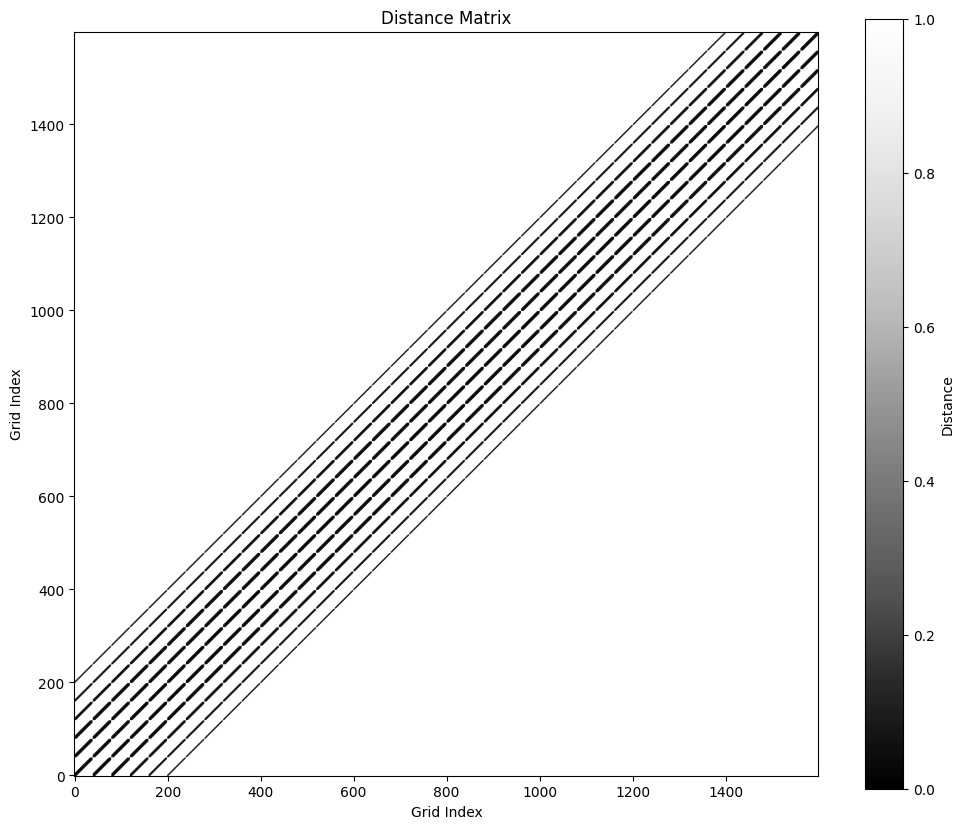

In [3]:
import numpy as np
import matplotlib.pyplot as plt

grid_x, grid_y = np.meshgrid(np.linspace(0, 1, 40), np.linspace(0, 1, 40))

# 중점 좌표를 0~9999번으로 인덱싱
center_indices = np.arange(10000)

center_coordinates = np.column_stack((grid_x.flatten(), grid_y.flatten()))
distances = np.sqrt(np.sum((center_coordinates[:, None, :] - center_coordinates[None, :, :])**2, axis=2)) / np.sqrt(2)

distances[distances > 0.1] = 1

plt.figure(figsize=(12, 10))
plt.imshow(distances, cmap='Greys_r')
plt.colorbar(label='Distance')
plt.title('Distance Matrix')
plt.xlabel('Grid Index')
plt.ylabel('Grid Index')
plt.gca().invert_yaxis()
plt.show()


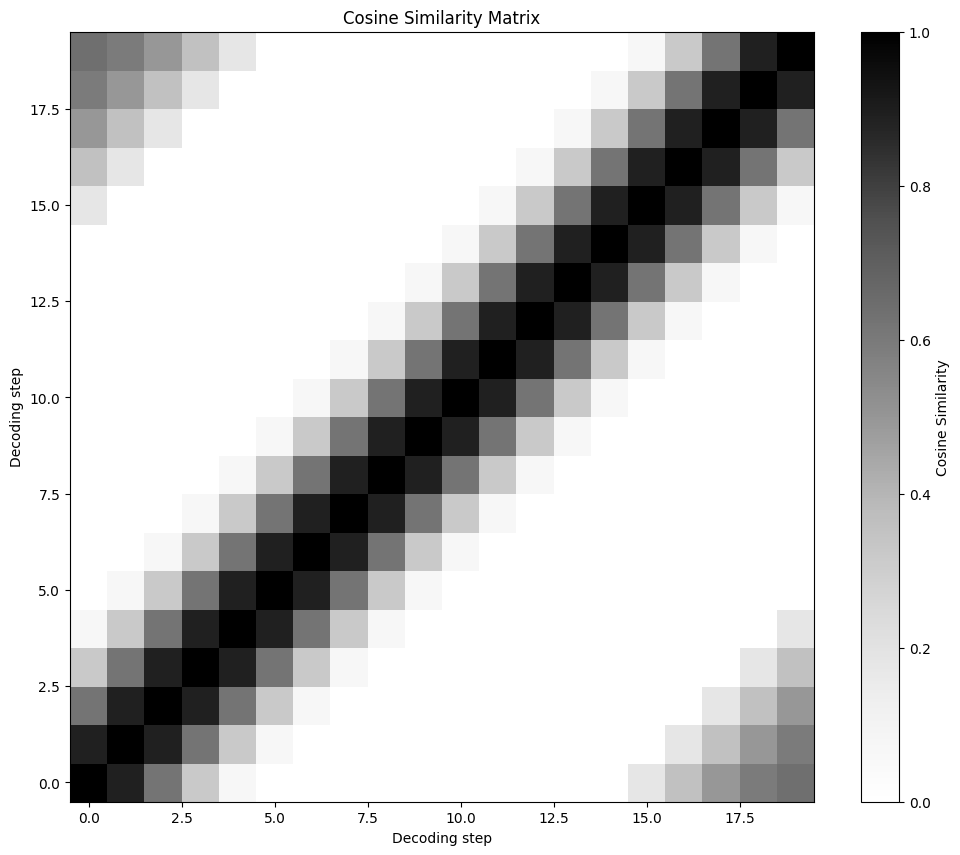

In [6]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

circular_pe = tsp_model.model.decoder_pe.pe.squeeze(0).cpu()

cosine_sim_matrix = cosine_similarity(circular_pe, circular_pe)

# 시각화
plt.figure(figsize=(12, 10))
plt.imshow(cosine_sim_matrix, cmap='Greys', aspect='auto', vmin=0, vmax=1)
plt.colorbar(label='Cosine Similarity')
plt.title('Cosine Similarity Matrix')
plt.xlabel('Decoding step')
plt.ylabel('Decoding step')
plt.gca().invert_yaxis()
plt.show()

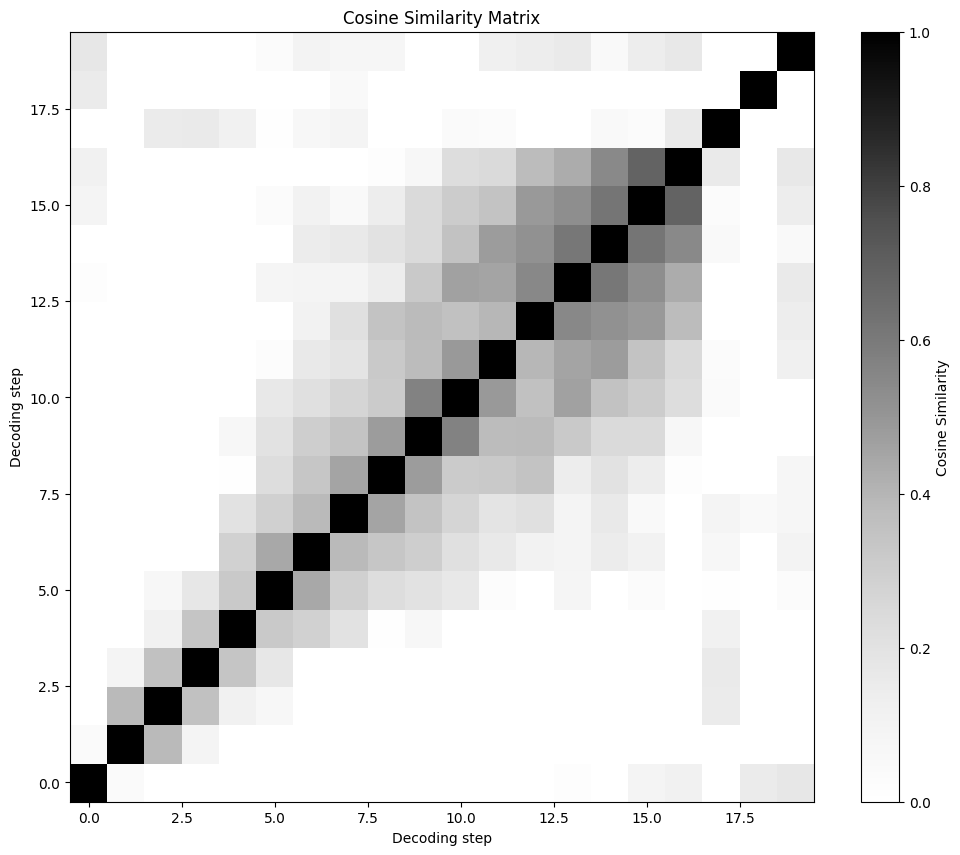

In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

circular_pe = tsp_model.model.decoder_pe.pe.squeeze(0).detach().cpu()

cosine_sim_matrix = cosine_similarity(circular_pe, circular_pe)

# 시각화
plt.figure(figsize=(12, 10))
plt.imshow(cosine_sim_matrix, cmap='Greys', aspect='auto', vmin=0, vmax=1)
plt.colorbar(label='Cosine Similarity')
plt.title('Cosine Similarity Matrix')
plt.xlabel('Decoding step')
plt.ylabel('Decoding step')
plt.gca().invert_yaxis()
plt.show()

['two way', 'one way']


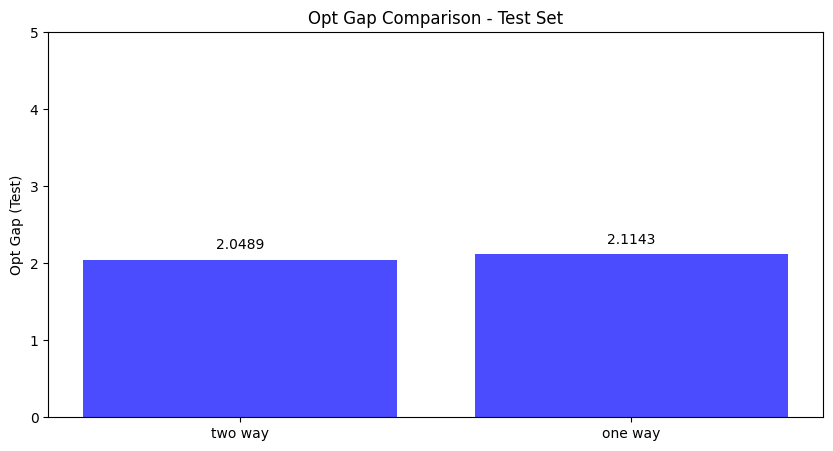

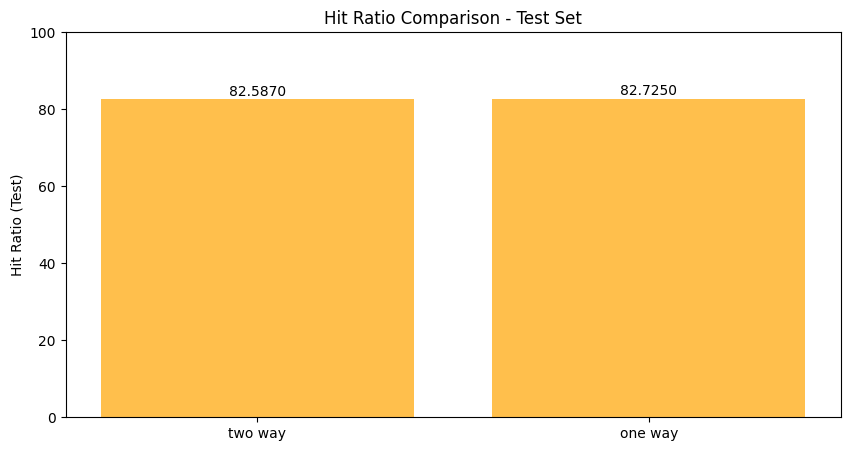

In [32]:
import matplotlib.pyplot as plt
import numpy as np
 
experiments = ['one way', "two way"] 
opt_gap_test = [ 2.1143, 2.0489 ]
hit_ratio_test = [ 82.7250, 82.587 ]

sorted_experiments = [exp for _, exp in sorted(zip(opt_gap_test, experiments))]
sorted_opt_gap_test = sorted(opt_gap_test)
sorted_hit_ratio_test = [hit_ratio_test[experiments.index(exp)] for exp in sorted_experiments]
print(sorted_experiments)

# 그래프 생성 (Opt Gap)
plt.figure(figsize=(10, 5))
plt.bar(sorted_experiments, sorted_opt_gap_test, color='blue', alpha=0.7)
plt.ylabel('Opt Gap (Test)')
plt.title('Opt Gap Comparison - Test Set')
plt.ylim(0, 5)  # 수치에 따라 적절히 조절
for i, v in enumerate(sorted_opt_gap_test):
    plt.text(i, v + 0.1, f'{v:.4f}', color='black', ha='center', va='bottom')
plt.show()

# 그래프 생성 (Hit Ratio)
plt.figure(figsize=(10, 5))
plt.bar(sorted_experiments, sorted_hit_ratio_test, color='orange', alpha=0.7)
plt.ylabel('Hit Ratio (Test)')
plt.title('Hit Ratio Comparison - Test Set')
plt.ylim(0, 100)  # 수치에 따라 적절히 조절
for i, v in enumerate(sorted_hit_ratio_test):
    plt.text(i, v + 0.1, f'{v:.4f}', color='black', ha='center', va='bottom')
plt.show()


In [1]:
from collections import deque
import random

def process_and_append_sequences(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    new_lines = []
    for line in lines:
        parts = line.split('output')
        if len(parts) == 2:
            before_output = parts[0].strip()
            sequence = parts[1].strip().split()
            if sequence:
                # 마지막 요소를 제거
                sequence.pop()
                sequence_deque = deque(sequence)

                # 시퀀스를 롤하고 결과를 저장
                for i in range(len(sequence)):
                    rolled_sequence = ' '.join(sequence_deque)
                    reversed_rolled_sequence = ' '.join(reversed(sequence_deque))
                    first = sequence_deque[0]
                    new_lines.append(f"{before_output} output {rolled_sequence} {first}\n")
                    new_lines.append(f"{before_output} output {first} {reversed_rolled_sequence}\n")
                    sequence_deque.rotate(1)  # 오른쪽으로 1만큼 롤
                    

    # 새로운 라인들을 랜덤하게 셔플
    #print(new_lines)
    random.shuffle(new_lines)

    with open("tsp20_grid40_train_40way(400000).txt", 'w') as file:  # 파일을 append 모드로 엽니다.
        for new_line in new_lines:
            file.write(new_line)
# 사용 예시
file_path = 'all_way.txt'
process_and_append_sequences(file_path)